# Top of Notebook: Assume that the classifier and regressor subcomponents have been trained

In [1]:
import pandas as pd
import numpy as np
import joblib
import importlib
import os
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    f1_score, confusion_matrix, log_loss,
    mean_squared_error, root_mean_squared_error,
    mean_absolute_error, r2_score, mean_tweedie_deviance, mean_gamma_deviance,
    mean_absolute_percentage_error
)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Add project path
project_path = '/content/drive/My Drive/CIS 5200 Final Project/code'
if project_path not in sys.path:
    sys.path.append(project_path)

from tqdm import trange
from tqdm import tqdm
import rf_regressor
import rf_classification
# import LGBMClass_pipeline
importlib.reload(rf_regressor)
importlib.reload(rf_classification)
# importlib.reload(LGBMClass_pipeline)
print("loaded pipelines.")

# import lightgbm as lgb
# # Try a tiny dummy training on GPU to see if it crashes
# try:
#     lgb.LGBMClassifier(device='gpu', verbose=-1).fit([[0], [1]], [0, 1])
#     print("GPU Acceleration is AVAILABLE.")
# except Exception as e:
#     print("GPU Acceleration is NOT available. Error:", e)


Mounted at /content/drive
loaded pipelines.


In [2]:
# --- CONFIGURATION ---
# Update these paths to your actual saved model files
CLASS_MODEL_PATH = "/content/drive/My Drive/CIS 5200 Final Project/models/random_forests/RF_CLS_cuML_RFClass_Dataset_added_delay_20251202_034422_20251206_211258.joblib"
REGR_MODEL_PATH = "/content/drive/My Drive/CIS 5200 Final Project/models/random_forests/RF_Reg_pos_only_20251207_195407.joblib"
# REGR_MODEL_PATH = "/content/drive/My Drive/CIS 5200 Final Project/models/random_forests/RF_Regressor_20251208_135411.joblib"
# Test Data Paths
mod = "added_delay_20251202_034422" # or "1", "2" etc. for the smaller datasets
DATA_FILE_PATH = "/content/drive/My Drive/CIS 5200 Final Project/train_test_datasets/"
X_TEST_PATH = DATA_FILE_PATH + f'X_test_{mod}.csv'
Y_TEST_PATH = DATA_FILE_PATH + f'y_test_{mod}.csv'

# Targets
CLS_TARGET = 'DEP_DEL15'       # Binary (0/1)
REG_TARGET = 'DEP_ADDED_DELAY' # Continuous (Minutes)

# Small Surgery for the regression model which had a bad parameter

In [ ]:
pipeline_wrapper = joblib.load(REGR_MODEL_PATH)
model = pipeline_wrapper.model
# LightGBM stores extra/unknown parameters in the '_other_params' dictionary
if hasattr(model, '_other_params') and 'stopping_rounds' in model._other_params:
    print(f"Found bad parameter: {model._other_params['stopping_rounds']}")
    del model._other_params['stopping_rounds']
    print("Successfully removed 'stopping_rounds' from model configuration.")
else:
    print("Parameter not found in _other_params.")

Parameter not found in _other_params.


In [ ]:
model._other_params

{'verbose': 1, 'metric': ['gamma', 'mae', 'rmse', 'r2']}

In [ ]:
# # 3. Save it back
# joblib.dump(pipeline_wrapper, REGR_MODEL_PATH)
# print("Saved cleaned model.")

Saved cleaned model.


# Try to put model prediction pipelines on gpu

In [17]:
pipeline = joblib.load(CLASS_MODEL_PATH)


In [18]:
pipeline


In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# Load saved pipeline (InferencePipeline)
pipeline = joblib.load(REGR_MODEL_PATH)

# Load test data
X_test = pd.read_csv(X_TEST_PATH)
y_test = pd.read_csv(Y_TEST_PATH)[REG_TARGET].squeeze()

# Transform features with stored preprocessor
X_test_trans = pipeline.preprocessor.transform(X_test)

# Predict
y_pred = pipeline.model.predict(X_test_trans)

# Compute metrics
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


R²:   0.5512
RMSE: 11.2878
MAE:  5.7796


In [ ]:
def load_model_on_gpu(model_path):
  pipeline = joblib.load(model_path)
  # Access the LightGBM model inside
  model = pipeline.model

  # Force parameter update to use GPU
  # We update the 'params' dictionary which LightGBM checks during prediction
  if hasattr(model, 'set_params'):
      print("Forcing GPU usage on loaded model...")
      model.set_params(device='gpu')
      # Optional: Set specific GPU device ID if needed (usually 0)
      # model.set_params(gpu_platform_id=0, gpu_device_id=0)

  # Verify
  print(f"Model device: {model.get_params().get('device')}")
  return pipeline

In [8]:
x_test = pd.read_csv(X_TEST_PATH)
y_test = pd.read_csv(Y_TEST_PATH)

In [9]:
y_test = y_test['DEP_DEL15']          # select just the label column
y_test = y_test.astype(int)

In [13]:
y_test

,DEP_DEL15
0,0
1,0
2,0
3,0
4,0
...,...
1271591,0
1271592,0
1271593,0
1271594,0


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
)

def evaluate_binary_clf(model, X_test, y_test, model_name="Model"):
    # 1. Predict probabilities (for positive class)
    y_proba = model.predict_proba(X_test)[:, 1]

    y_pred = (y_proba >= 0.5).astype(int)  # or your chosen threshold

    # 2. ROC & AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)



    # 3. PR curve & AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)

    # 4. Plot ROC – formatted like the example figure
    plt.figure(figsize=(6, 5))

    # ROC curve for the model
    plt.plot(
        fpr,
        tpr,
        label=f"Random Forest (AUC = {roc_auc:.3f})"
    )

    # Diagonal "random" baseline
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        label="Random"
    )

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – Random Forest (DEP_DEL15)")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(alpha=0.3)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


    # 5. Plot Precision–Recall
    plt.figure()
    plt.plot(recall, precision, label=f"{model_name} (AUPRC = {auprc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve – {model_name}")
    plt.legend()
    plt.show()

    # 6. Other metrics (printed)
    print(f"\n=== {model_name} Metrics ===")
    print(f"ROC AUC:  {roc_auc:.3f}")
    print(f"AUPRC:    {auprc:.3f}")
    print(f"Balanced Accuracy:    {bal_acc:.3f}")
    print(f"Accuracy:    {acc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))


In [22]:
pipeline.model

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

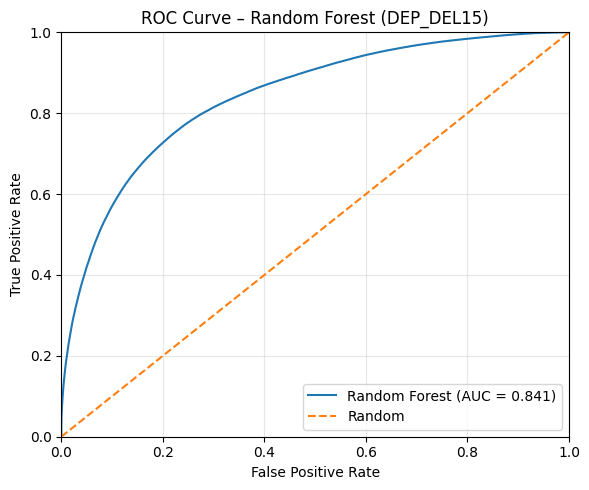

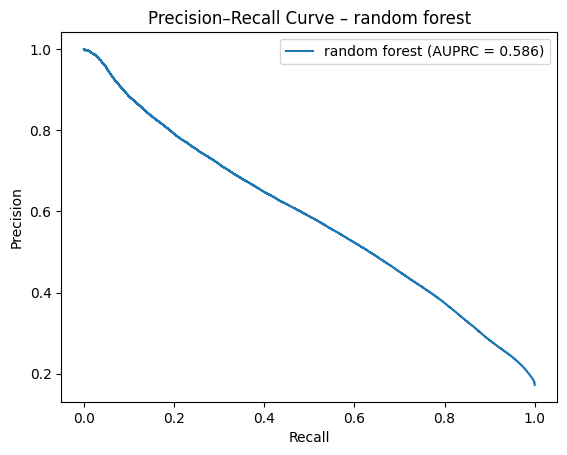


=== random forest Metrics ===
ROC AUC:  0.841
AUPRC:    0.586
Balanced Accuracy:    0.764
Accuracy:    0.759

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84   1052339
           1       0.40      0.77      0.52    219257

    accuracy                           0.76   1271596
   macro avg       0.67      0.76      0.68   1271596
weighted avg       0.85      0.76      0.78   1271596


Confusion matrix:
[[795268 257071]
 [ 49912 169345]]


In [27]:
evaluate_binary_clf(pipeline, x_test, y_test, model_name="random forest")


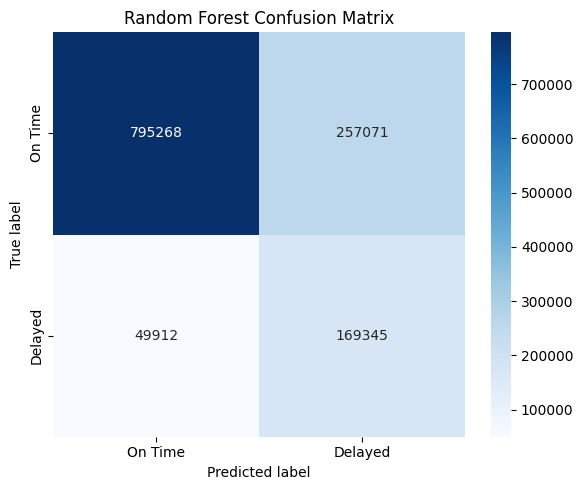

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix values
cm = np.array([
    [795268, 257071],
    [ 49912, 169345]
])

labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["On Time", "Delayed"],
            yticklabels=["On Time", "Delayed"])

plt.title("Random Forest Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


# Hurdle Model Definition

In [ ]:
import gc

class HurdleModel:
    def __init__(self, classifier_path, regressor_path):
        print(f"Loading Classifier: {classifier_path}...")
        # self.clf_pipeline = load_model_on_gpu(classifier_path)
        self.clf_pipeline = joblib.load(classifier_path)

        print(f"Loading Regressor: {regressor_path}...")
        # self.reg_pipeline = load_model_on_gpu(regressor_path)
        self.reg_pipeline = joblib.load(regressor_path)

    def predict(self, X, threshold=0.5, method='expected', batch_size=50000):
        """
        Runs inference in batches to prevent RAM spikes/hanging.
        """
        n_samples = len(X)
        print(f"Starting batched inference on {n_samples} samples...")

        probs_list = []
        mags_list = []

        # Loop through data in chunks
        for i in trange(0, n_samples, batch_size):
            # 1. Slice the batch
            # Use .iloc to get a clean slice, .copy() to ensure no memory leakage
            batch = X.iloc[i : i + batch_size].copy()

            # --- CLASSIFIER (Probabilities) ---
            if hasattr(self.clf_pipeline, 'predict_proba'):
                # Standard Sklearn Pipeline
                p_batch = self.clf_pipeline.predict_proba(batch)[:, 1]
            else:
                # Custom InferencePipeline wrapper
                # We access the internal preprocessor/model manually to be safe
                batch_trans = self.clf_pipeline.preprocessor.transform(batch)
                p_batch = self.clf_pipeline.model.predict_proba(batch_trans)[:, 1]

            probs_list.append(p_batch)

            # --- REGRESSOR (Magnitudes) ---
            if hasattr(self.reg_pipeline, 'predict'):
                m_batch = self.reg_pipeline.predict(batch)
            else:
                batch_trans_reg = self.reg_pipeline.preprocessor.transform(batch)
                m_batch = self.reg_pipeline.model.predict(batch_trans_reg)

            mags_list.append(m_batch)

            # Progress Log
            if (i // batch_size) % 2 == 0:
                print(f"  Processed {min(i + batch_size, n_samples)} / {n_samples} rows...")

            # Clean up batch memory immediately
            del batch
            # If using custom transforms, clean those intermediate variables too
            if 'batch_trans' in locals(): del batch_trans
            if 'batch_trans_reg' in locals(): del batch_trans_reg
            gc.collect()

        print("Batching complete. Concatenating results...")

        # 2. Reassemble
        probs = np.concatenate(probs_list)
        magnitudes = np.concatenate(mags_list)

        # Safety: Ensure no negative predictions
        magnitudes = np.maximum(magnitudes, 0)

        # 3. Combine Logic
        if method == 'expected':
            return probs * magnitudes

        elif method == 'hard':
            mask = probs >= threshold
            final_preds = np.zeros_like(probs)
            final_preds[mask] = magnitudes[mask]
            return final_preds

        elif method == 'raw':
            return probs, magnitudes

print("Hurdle Model (Batched) Defined Successfully.")

Hurdle Model (Batched) Defined Successfully.


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
# 1. Instantiate the Combined Model
hurdle_model = HurdleModel(CLASS_MODEL_PATH, REGR_MODEL_PATH)

# 2. Load Test Data
print("Loading Test Data...")
X_test = pd.read_csv(X_TEST_PATH)
y_test_df = pd.read_csv(Y_TEST_PATH)

# Extract both targets
y_test_binary = y_test_df[CLS_TARGET]
y_test_value = y_test_df[REG_TARGET]

print(f"Test Data Loaded.")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test_binary.shape}")

Loading Classifier: /content/drive/My Drive/CIS 5200 Final Project/models/random_forests/RF_CLS_cuML_RFClass_Dataset_added_delay_20251202_034422_20251206_211258.joblib...
Loading Regressor: /content/drive/My Drive/CIS 5200 Final Project/models/random_forests/RF_Reg_pos_only_20251207_195407.joblib...
Loading Test Data...
Test Data Loaded.
X_test Shape: (1271596, 49)
y_test Shape: (1271596,)


In [ ]:
# Generate Predictions
print("Running Inference...")

# 1. Get Component Predictions (for individual analysis)
probs, magnitudes = hurdle_model.predict(X_test, method='raw')

# 2. Get Combined Predictions (Expected Delay)
# This smoothes the output: A 50% chance of 20 mins = 10 mins expected delay
y_pred_expected = probs * magnitudes

# 3. Get Combined Predictions (Hard Decision @ 0.5 threshold)
# Either 0 mins OR the full regressor amount
y_pred_hard = np.where(probs >= 0.5, magnitudes, 0)

print("Inference Complete.")

Running Inference...
Starting batched inference on 1271596 samples...


  4%|▍         | 1/26 [00:08<03:43,  8.93s/it]

  Processed 50000 / 1271596 rows...


 12%|█▏        | 3/26 [00:18<02:13,  5.79s/it]

  Processed 150000 / 1271596 rows...


 19%|█▉        | 5/26 [00:26<01:34,  4.48s/it]

  Processed 250000 / 1271596 rows...


 27%|██▋       | 7/26 [00:34<01:23,  4.38s/it]

  Processed 350000 / 1271596 rows...


 35%|███▍      | 9/26 [00:41<01:06,  3.92s/it]

  Processed 450000 / 1271596 rows...


 42%|████▏     | 11/26 [00:51<01:08,  4.54s/it]

  Processed 550000 / 1271596 rows...


 50%|█████     | 13/26 [00:59<00:54,  4.17s/it]

  Processed 650000 / 1271596 rows...


 58%|█████▊    | 15/26 [01:06<00:43,  3.98s/it]

  Processed 750000 / 1271596 rows...


 65%|██████▌   | 17/26 [01:15<00:37,  4.18s/it]

  Processed 850000 / 1271596 rows...


 73%|███████▎  | 19/26 [01:22<00:26,  3.81s/it]

  Processed 950000 / 1271596 rows...


 81%|████████  | 21/26 [01:30<00:20,  4.04s/it]

  Processed 1050000 / 1271596 rows...


 88%|████████▊ | 23/26 [01:37<00:11,  3.75s/it]

  Processed 1150000 / 1271596 rows...


 96%|█████████▌| 25/26 [01:46<00:03,  3.91s/it]

  Processed 1250000 / 1271596 rows...


100%|██████████| 26/26 [01:47<00:00,  4.15s/it]

Batching complete. Concatenating results...
Inference Complete.


In [ ]:
a = pd.Series(y_pred_expected)

In [ ]:
a.describe()

,0
count,1.271596e+06
mean,1.116453e+01
std,6.976787e+00
min,7.151099e-01
25%,6.926697e+00
50%,1.034587e+01
75%,1.356478e+01
max,9.568613e+01


In [ ]:
len(probs)

1271596

In [ ]:
SAVE_PREDICTIONS_PATH = "/content/drive/My Drive/CIS 5200 Final Project/models/random_forests/"
predictions = {'probs': probs, 'magnitudes': magnitudes,
               'y_pred_expected': y_pred_expected,
               'y_pred_hard': y_pred_hard,
               'y_test': y_test_value}


In [ ]:
import pickle as pkl
print("\n" + "="*30)
print("FULL HURDLE MODEL PERFORMANCE")
print("(Evaluated on ALL flights, including zeros)")
print("="*30)

# Evaluate 'Expected Value' predictions against True Values (which include 0s)
rmse_full = root_mean_squared_error(y_test_value, y_pred_expected)
mae_full = mean_absolute_error(y_test_value, y_pred_expected)
r2_full = r2_score(y_test_value, y_pred_expected)
tweedie_deviance_full = mean_tweedie_deviance(y_test_value, y_pred_expected, power=1.5)
mse_full = mean_squared_error(y_test_value, y_pred_expected)
# mape_full = mean_absolute_percentage_error(y_test_value, y_pred_expected)
print(f"RMSE (Full Dataset): {rmse_full:.4f} min")
print(f"MSE (Full Dataset):  {mse_full:.4f}")
print(f"MAE (Full Dataset):  {mae_full:.4f} min")
# print(f"Mean Tweedie Deviance (Full Dataset):  {tweedie_deviance_full:.4f}")
# print(f"MAPE (Full Dataset):  {mape_full:.4f}")
print(f"R2 (Full Dataset):   {r2_full:.4f}")


FULL HURDLE MODEL PERFORMANCE
(Evaluated on ALL flights, including zeros)
RMSE (Full Dataset): 14.2368 min
MSE (Full Dataset):  202.6872
MAE (Full Dataset):  10.8904 min
R2 (Full Dataset):   0.2861


In [ ]:
performance = {'rmse': rmse_full, 'mae': mae_full, 'r2': r2_full, 'tweedie_deviance': tweedie_deviance_full}
predictions.update(performance)
with open(SAVE_PREDICTIONS_PATH+"LightGBMHurdle_BinaryClass_GammaRegr_predictions_and_metrics.json", 'wb') as f:
      pkl.dump(predictions, f)

In [ ]:
with open(SAVE_PREDICTIONS_PATH+"LightGBMHurdle_BinaryClass_GammaRegr_predictions_and_metrics.json", 'rb') as f:
      load_preds = pkl.load(f)


In [ ]:
load_preds

{'probs': array([0.06372176, 0.03521345, 0.26735272, ..., 0.13421509, 0.01312261,
        0.28428095]),
 'magnitudes': array([5.27104985, 4.01157434, 8.01246946, ..., 2.30685022, 5.15016355,
        0.7877008 ]),
 'y_pred_expected': array([0.33588056, 0.14126136, 2.14215553, ..., 0.3096141 , 0.06758359,
        0.22392833]),
 'y_pred_hard': array([0., 0., 0., ..., 0., 0., 0.]),
 'y_test': 0          0
 1          0
 2          0
 3          0
 4          0
           ..
 1271591    0
 1271592    0
 1271593    0
 1271594    0
 1271595    0
 Name: DEP_ADDED_DELAY, Length: 1271596, dtype: int64,
 'rmse': 9.376102479486024,
 'mae': 3.224749483521872,
 'r2': 0.6903674500949246,
 'tweedie_deviance': 3.7667131021013613}